# 0.1 Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from typing import Dict, List, Tuple, Sequence
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

# 1. Training Data Import & Cleaning

In [ ]:
current_dir = os.getcwd()
current_dir

'/content'

In [ ]:
relative_path = os.path.dirname(current_dir)
relative_path

'/'

In [ ]:
file_name = "raw_fitting.csv"

file_path = os.path.join(current_dir, file_name)

df = pd.read_csv(file_path, parse_dates=['date'], usecols=lambda col: col != '')

In [ ]:
# Drop the first weird column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.shape

(131496, 23)

In [ ]:
df.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m',
       'sunshine_duration'],
      dtype='object')

In [ ]:
df.dtypes

,0
date,datetime64[ns]
temperature_2m,float64
relative_humidity_2m,float64
dew_point_2m,float64
precipitation,float64
rain,float64
snowfall,float64
snow_depth,float64
weather_code,float64
pressure_msl,float64


In [ ]:
df.tail(2)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
131494,2024-01-01 22:00:00,-13.721,80.381676,-16.371,0.0,0.0,0.0,1.23,3.0,1016.9,...,2.0,100.0,0.0,0.041773,6.763786,12.429127,154.79890,190.00792,26.28,0.679
131495,2024-01-01 23:00:00,-13.421,78.443700,-16.371,0.0,0.0,0.0,1.23,1.0,1015.7,...,0.0,40.0,0.0,0.047036,6.439876,12.605142,153.43501,181.63654,27.00,0.679


## 1.1 Splitting DF into X and y for scaling

In [ ]:
df = df.drop_duplicates()
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
0,2009-01-01 00:00:00,-10.842501,72.968170,-14.742500,0.0,0.0,0.00,0.92,3.0,1025.2,...,95.0,24.0,0.001225,0.072607,6.989935,11.275530,191.88864,196.69933,29.880000,-0.1425
1,2009-01-01 01:00:00,-10.642500,73.911520,-14.392500,0.0,0.0,0.00,0.92,3.0,1025.2,...,95.0,46.0,0.000000,0.071200,5.860375,8.557102,190.61960,202.24907,25.560000,-0.1425
2,2009-01-01 02:00:00,-10.492500,74.547844,-14.142500,0.1,0.0,0.07,0.92,71.0,1025.0,...,89.0,51.0,0.000000,0.070298,5.154416,6.696387,192.09474,216.25392,20.160000,-0.1925
3,2009-01-01 03:00:00,-10.442499,75.476270,-13.942499,0.1,0.0,0.07,0.92,71.0,1025.3,...,92.0,75.0,0.000000,0.068005,3.758510,4.896529,196.69933,252.89719,15.119999,-0.1925
4,2009-01-01 04:00:00,-10.542500,78.596596,-13.542500,0.2,0.0,0.14,0.93,71.0,1025.5,...,92.0,81.0,0.000000,0.058886,2.099143,5.860375,239.03630,317.48960,14.759999,-0.1925


def label_encode_columns(cat_data, cat_columns):
    """Apply LabelEncoder to specified categorical columns."""
    for col in cat_columns:
        cat_data[col] = LabelEncoder().fit_transform(cat_data[col])
    return cat_data

def preprocess(data):
    """
    Process the input data X by adding cylical feature, applying label encoding to categorical columns
    and standard scaling to numerical columns.
    Parameters:
        X (pd.DataFrame): Input dataframe to process.
    Returns:
        pd.DataFrame: Processed dataframe.
    """

    # Check if the DataFrame index is a datetime-like index
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a datetime-like index (e.g., pd.DatetimeIndex). "
                        "Ensure your DataFrame has a datetime index using data.set_index().")

    #Add cyclical features
    data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)

    data['month_sin'] = np.sin(2 * np.pi * (data.index.month - 1) / 12)
    data['month_cos'] = np.cos(2 * np.pi * (data.index.month - 1) / 12)

    # Define categorical and numerical columns
    cat_columns = ['weather_code']
    num_columns = data.drop(columns=cat_columns).select_dtypes(include=['float64']).columns.tolist()

    # Helper function to generate column names for label-encoded columns
    def get_label_encoded_column_names(cat_columns):
        return [f"{col}_encoded" for col in cat_columns]

    # Define the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            # Apply FunctionTransformer to label encode categorical columns
            ('label_encoder', FunctionTransformer(lambda data: label_encode_columns(data, cat_columns), validate=False), cat_columns),

            # Apply StandardScaler to numerical columns
            ('standard_scaler', StandardScaler(), num_columns)
        ],
        remainder='passthrough'  # Keeps other columns as is
    )

    # Create the pipeline
    preprocess_pipe = make_pipeline(preprocessor)

    # Process and return the transformed data
    processed_data = preprocess_pipe.fit_transform(data)

    # Convert to DataFrame to maintain column names
    processed_columns = get_label_encoded_column_names(cat_columns) + num_columns + list(data.columns.difference(cat_columns + num_columns))

    print("✅ Processed data, with shape", processed_data.shape)

    # print(processed_columns)

    return pd.DataFrame(processed_data, columns=processed_columns)

In [ ]:
def label_encode_columns(cat_data, cat_columns):
    """Apply LabelEncoder to specified categorical columns."""
    for col in cat_columns:
        cat_data[col] = LabelEncoder().fit_transform(cat_data[col])
    return cat_data

In [ ]:
# Define label encoding function outside of the preprocess_training function
def apply_label_encoding(data, cat_columns):
    return label_encode_columns(data, cat_columns)

# Updated preprocess_training function
def preprocess_training(data):
    """
    Process the input data X by adding cyclical features, applying label encoding
    to categorical columns, and standard scaling to numerical columns.
    """
    # Check if the DataFrame index is a datetime-like index
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a datetime-like index (e.g., pd.DatetimeIndex). "
                         "Ensure your DataFrame has a datetime index using data.set_index().")

    # Add cyclical features
    data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)

    data['month_sin'] = np.sin(2 * np.pi * (data.index.month - 1) / 12)
    data['month_cos'] = np.cos(2 * np.pi * (data.index.month - 1) / 12)

    # Define categorical and numerical columns
    cat_columns = ['weather_code']
    num_columns = data.drop(columns=cat_columns).select_dtypes(include=['float64']).columns.tolist()

    # Define the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            # Apply the named function for label encoding
            ('label_encoder', FunctionTransformer(apply_label_encoding, kw_args={'cat_columns': cat_columns}, validate=False), cat_columns),

            # Apply StandardScaler to numerical columns
            ('standard_scaler', StandardScaler(), num_columns)
        ],
        remainder='passthrough'  # Keeps other columns as is
    )

    # Create the pipeline
    preprocess_pipe = make_pipeline(preprocessor)

    # Process and return the transformed data
    processed_data = preprocess_pipe.fit_transform(data)

    # Generate column names
    processed_columns = [f"{col}_encoded" for col in cat_columns] + num_columns + list(data.columns.difference(cat_columns + num_columns))

    print("✅ Processed data, with shape", processed_data.shape)

    return preprocess_pipe, pd.DataFrame(processed_data, columns=processed_columns)

In [ ]:
X = df.drop(columns = 'snow_depth')
X['date'] = pd.to_datetime(X['date'])
X.set_index('date', inplace=True)
y = df[['date','snow_depth']]

In [ ]:
X.shape

(131496, 21)

In [ ]:
preprocessor, X_processed = preprocess_training(X)

✅ Processed data, with shape (131496, 27)


In [ ]:
len(X_processed.columns)

27

In [ ]:
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label_encoder',
                                                  FunctionTransformer(func=<function apply_label_encoding at 0x7e98db5e1750>,
                                                                      kw_args={'cat_columns': ['weather_code']}),
                                                  ['weather_code']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temperature_2m',
                                                   'relative_humidity_2m',
                                                   'dew_point_2m',
                                                   'precipitation',...
                                                   'snowfall', 'pressure_msl',
                                                   'surface_pressure',
                                                   'cloud_cover',
                                                   'cloud_cover_low',
                                                   'cloud_cover_mid',
                                                   'cloud_cover_high',
                                                   'et0_fao_evapotranspiration',
                                                   'vapour_pressure_deficit',
                                                   'wind_speed_10m',
                                                   'wind_speed_100m',
                                                   'wind_direction_10m',
                                                   'wind_direction_100m',
                                                   'wind_gusts_10m',
                                                   'sunshine_duration',
                                                   'hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos',
                                                   'month_sin',
                                                   'month_cos'])]))])

In [434]:
!pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.9 MB/s eta 0:00:00


In [436]:
import dill

dill.settings['recurse'] = True
with open('preprocessor_snow_depth.dill', 'wb') as file:
  dill.dump(preprocessor, file)

In [ ]:
df = pd.concat([y.reset_index(drop=True), X_processed], axis=1)

In [ ]:
train_df = df.copy()
df.head(1)

,date,snow_depth,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2009-01-01,0.92,3.0,-1.565276,-0.359492,-1.676971,-0.389763,-0.272938,-0.289634,0.915229,...,-0.038465,0.000227,0.164295,-0.722739,2.619209e-17,1.414214,0.614121,-1.273928,0.004523,1.419691


# 2. Load Transformer Model Snow Depth

In [ ]:
from darts import TimeSeries
from darts.models import TransformerModel, BlockRNNModel
from darts.metrics import mae, mape

In [ ]:
loaded_model = TransformerModel.load("/content/snow_depth_model_1.pt")

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

# 4. Prediction

## 4.1 Best_model

### 4.1.1 Get Current data

#### Imports & Function Definintion

In [ ]:
!pip install openmeteo_requests requests_cache retry_requests google-cloud-bigquery colorama

In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
from requests.exceptions import RequestException
from google.cloud import bigquery
from colorama import Fore, Style
from datetime import datetime as dt
from datetime import timedelta
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
def label_encode_columns(cat_data, cat_columns):
    """Apply LabelEncoder to specified categorical columns."""
    for col in cat_columns:
        cat_data[col] = LabelEncoder().fit_transform(cat_data[col])
    return cat_data

In [ ]:
def preprocess_pred_snow_depth(data, preprocessor):
    """
    Process the input data X by adding cylical feature, applying label encoding to categorical columns
    and standard scaling to numerical columns.
    Parameters:
        X (pd.DataFrame): Input dataframe to process.
    Returns:
        pd.DataFrame: Processed dataframe.
    """

    # Check if the DataFrame index is a datetime-like index
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a datetime-like index (e.g., pd.DatetimeIndex). "
                        "Ensure your DataFrame has a datetime index using data.set_index().")

    #Add cyclical features
    data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)

    data['month_sin'] = np.sin(2 * np.pi * (data.index.month - 1) / 12)
    data['month_cos'] = np.cos(2 * np.pi * (data.index.month - 1) / 12)

    # Process and return the transformed data
    processed_data = preprocessor.transform(data)

    # Convert to DataFrame to maintain column names
    processed_columns = ['temperature_2m',
                         'weather_code_encoded',
                         'relative_humidity_2m',
                         'dew_point_2m',
                         'precipitation',
                         'rain',
                         'snowfall',
                         'pressure_msl',
                         'surface_pressure',
                         'cloud_cover',
                         'cloud_cover_low',
                         'cloud_cover_mid',
                         'cloud_cover_high',
                         'et0_fao_evapotranspiration',
                         'vapour_pressure_deficit',
                         'wind_speed_10m',
                         'wind_speed_100m',
                         'wind_direction_10m',
                         'wind_direction_100m',
                         'wind_gusts_10m',
                         'sunshine_duration',
                         'hour_sin',
                         'hour_cos',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos']


    print(":white_check_mark: Processed data, with shape", processed_data.shape)

    # print(processed_columns)

    return pd.DataFrame(processed_data, columns=processed_columns)

In [ ]:
def fetch_prediction_data(latitude, longitude, variables=None, models="best_match"):
    """
    Fetch prediction data from the Open-Meteo API, processing hourly weather data for the last `prediction_length` days.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        prediction_length (int): Number of past days to fetch data for.
        models (str): Weather model (default: "best_match").

    Returns:
        pd.DataFrame: Hourly weather data as a Pandas DataFrame or None if the API request fails.
    """
    # Set up the Open-Meteo API client with cache and retry
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Weather variables
    variables = [
        "temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation",
        "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl",
        "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
        "cloud_cover_high", "et0_fao_evapotranspiration", "vapour_pressure_deficit",
        "wind_speed_10m", "wind_speed_120m", "wind_direction_10m", "wind_direction_120m",
        "wind_gusts_10m", "sunshine_duration"
    ]

    # API parameters
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "past_hours": 48,  # Number of past days to fetch
        "forecast_hours": 48,  # Only fetch past data
        "hourly": variables,
        "models": models
    }

    try:
        # Fetch the weather data
        responses = openmeteo.weather_api(url, params=params)

        # Ensure the response is valid
        if not responses or len(responses) == 0:
            raise ValueError("No response received from the Open-Meteo API.")

        # Process first location
        response = responses[0]
        print(f"Coordinates: {response.Latitude()}°N, {response.Longitude()}°E")
        print(f"Elevation: {response.Elevation()} m asl")
        print(f"Timezone: {response.Timezone()} ({response.TimezoneAbbreviation()})")
        print(f"UTC Offset: {response.UtcOffsetSeconds()} seconds")

        # Process hourly data
        hourly = response.Hourly()
        hourly_data = {"date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )}

        # Assign hourly variables
        hourly_data["temperature_2m"] = hourly.Variables(0).ValuesAsNumpy()
        hourly_data["relative_humidity_2m"] = hourly.Variables(1).ValuesAsNumpy()
        hourly_data["dew_point_2m"] = hourly.Variables(2).ValuesAsNumpy()
        hourly_data["precipitation"] = hourly.Variables(3).ValuesAsNumpy()
        hourly_data["rain"] = hourly.Variables(4).ValuesAsNumpy()
        hourly_data["snowfall"] = hourly.Variables(5).ValuesAsNumpy()
        hourly_data["snow_depth"] = hourly.Variables(6).ValuesAsNumpy()
        hourly_data["weather_code"] = hourly.Variables(7).ValuesAsNumpy()
        hourly_data["pressure_msl"] = hourly.Variables(8).ValuesAsNumpy()
        hourly_data["surface_pressure"] = hourly.Variables(9).ValuesAsNumpy()
        hourly_data["cloud_cover"] = hourly.Variables(10).ValuesAsNumpy()
        hourly_data["cloud_cover_low"] = hourly.Variables(11).ValuesAsNumpy()
        hourly_data["cloud_cover_mid"] = hourly.Variables(12).ValuesAsNumpy()
        hourly_data["cloud_cover_high"] = hourly.Variables(13).ValuesAsNumpy()
        hourly_data["et0_fao_evapotranspiration"] = hourly.Variables(14).ValuesAsNumpy()
        hourly_data["vapour_pressure_deficit"] = hourly.Variables(15).ValuesAsNumpy()
        hourly_data["wind_speed_10m"] = hourly.Variables(16).ValuesAsNumpy()
        hourly_data["wind_speed_100m"] = hourly.Variables(17).ValuesAsNumpy()  # Renamed for train dataset
        hourly_data["wind_direction_10m"] = hourly.Variables(18).ValuesAsNumpy()
        hourly_data["wind_direction_100m"] = hourly.Variables(19).ValuesAsNumpy()  # Renamed for train dataset
        hourly_data["wind_gusts_10m"] = hourly.Variables(20).ValuesAsNumpy()
        hourly_data["sunshine_duration"] = hourly.Variables(21).ValuesAsNumpy()

        # Create a DataFrame
        hourly_dataframe = pd.DataFrame(data=hourly_data)
        print(f"✅ Prediction data fetched successfully")
        print(f"Shape: {hourly_dataframe.shape}")
        print(hourly_dataframe.dtypes)
        return hourly_dataframe

    except RequestException as req_err:
        print(f"❌ API request failed due to a network issue: {req_err}")
    except ValueError as val_err:
        print(f"❌ API response error: {val_err}")
    except Exception as ex:
        print(f"❌ An unexpected error occurred: {ex}")

    # Return None if the data could not be fetched
    return None

In [418]:
pred_df = fetch_prediction_data(47.26580883196723, 11.84457426992035, variables=None, models="best_match")

Coordinates: 47.2400016784668°N, 11.84000015258789°E
Elevation: 1818.0 m asl
Timezone: None (None)
UTC Offset: 0 seconds
✅ Prediction data fetched successfully
Shape: (96, 23)
date                          datetime64[ns, UTC]
temperature_2m                            float32
relative_humidity_2m                      float32
dew_point_2m                              float32
precipitation                             float32
rain                                      float32
snowfall                                  float32
snow_depth                                float32
weather_code                              float32
pressure_msl                              float32
surface_pressure                          float32
cloud_cover                               float32
cloud_cover_low                           float32
cloud_cover_mid                           float32
cloud_cover_high                          float32
et0_fao_evapotranspiration                float32
vapour_pressure_deficit 

In [422]:
pred_df

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
0,2024-12-17 08:00:00,2.576000,62.0,-3.976741,0.0,0.0,0.0,0.19,0.0,1030.300049,...,0.0,0.0,0.018731,0.280208,5.860375,8.404285,317.489594,313.264343,41.399998,1690.961426
1,2024-12-17 09:00:00,3.676000,56.0,-4.296846,0.0,0.0,0.0,0.19,0.0,1029.199951,...,0.0,0.0,0.065959,0.350694,8.942214,15.141414,310.100830,298.392914,36.000000,3600.000000
2,2024-12-17 10:00:00,4.576000,53.0,-4.189730,0.0,0.0,0.0,0.19,0.0,1028.599976,...,0.0,0.0,0.101182,0.399016,6.915374,13.849477,308.659821,297.897186,47.160000,3600.000000
3,2024-12-17 11:00:00,4.526000,55.0,-3.742100,0.0,0.0,0.0,0.19,0.0,1029.099976,...,0.0,0.0,0.118263,0.380709,1.440000,4.198285,360.000000,300.963684,42.480000,3600.000000
4,2024-12-17 12:00:00,4.426000,55.0,-3.835533,0.0,0.0,0.0,0.18,0.0,1028.099976,...,0.0,0.0,0.124962,0.378054,6.379216,10.464797,343.610382,319.185028,34.919998,3600.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-12-21 03:00:00,-8.874000,55.0,-16.284662,0.0,0.0,0.0,0.31,3.0,1025.500000,...,100.0,68.0,0.009036,0.141158,7.421590,3.219938,284.036255,243.435013,27.000000,0.000000
92,2024-12-21 04:00:00,-8.573999,50.0,-17.144499,0.0,0.0,0.0,0.30,3.0,1025.199951,...,93.0,6.0,0.012987,0.160547,8.350138,4.394360,277.431305,235.007904,30.599998,0.000000
93,2024-12-21 05:00:00,-8.274000,48.0,-17.352493,0.0,0.0,0.0,0.30,3.0,1024.900024,...,91.0,1.0,0.015004,0.170916,8.825508,4.349896,281.768250,245.556061,31.319998,0.000000
94,2024-12-21 06:00:00,-7.974000,48.0,-17.075258,0.0,0.0,0.0,0.30,3.0,1024.800049,...,100.0,0.0,0.014069,0.174957,8.209263,3.758510,285.255157,253.300674,32.039997,0.000000


#### Preprocess Current Data for Prediction

In [423]:
current_time = dt.now()

In [424]:
pred_df['date'] = pd.to_datetime(pred_df['date'], errors='coerce').dt.tz_localize(None)
pred_df.head(1)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
0,2024-12-17 08:00:00,2.576,62.0,-3.976741,0.0,0.0,0.0,0.19,0.0,1030.300049,...,0.0,0.0,0.018731,0.280208,5.860375,8.404285,317.489594,313.264343,41.399998,1690.961426


In [425]:
X = pred_df.drop(columns = 'snow_depth')
X['date'] = pd.to_datetime(X['date'])
X = X.set_index('date')
y = pred_df[['date','snow_depth']]

In [426]:
X.shape , y.shape

((96, 21), (96, 2))

In [427]:
'snow_depth' in X.columns

False

In [428]:
X_processed = preprocess_pred_snow_depth(X, preprocessor)

:white_check_mark: Processed data, with shape (96, 27)


In [429]:
len(X_processed.columns)

27

In [430]:
df = pd.concat([y.reset_index(drop=True), X_processed], axis=1)
df.shape

(96, 29)

In [431]:
df = pd.concat([y.reset_index(drop=True), X_processed], axis=1)
print(df.shape)
df.head(1)


(96, 29)


,date,snow_depth,temperature_2m,weather_code_encoded,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2024-12-17 08:00:00,0.19,0.0,0.047804,-0.998545,-0.316519,-0.389763,-0.272938,-0.289634,1.557253,...,1.232062,1.102559,1.001306,323.690107,1.224745,-0.707107,1.106244,0.881761,-0.702752,1.230262


In [ ]:
df = df.head(48) # get rid of upcoming input or less then 48h input

In [ ]:
df.shape

(48, 29)

In [ ]:
last_48h = df.tail(48)

In [ ]:
df.tail(2)

,date,snow_depth,temperature_2m,weather_code_encoded,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
46,2024-12-19 06:00:00,0.16,2.0,1.414214,1.658337e-16,0.215889,-0.862312,-1.110223e-16,0.0,5.176,...,0.0,100.0,0.042155,0.460310,12.496718,17.709658,221.496368,206.564987,45.360001,0.0
47,2024-12-19 07:00:00,0.16,1.0,1.366025,-3.660254e-01,0.215889,-0.862312,-1.110223e-16,0.0,5.326,...,33.0,0.0,0.044143,0.491958,12.031756,18.057508,218.927551,203.498581,46.079998,0.0


In [ ]:
df.columns

Index(['date', 'snow_depth', 'temperature_2m', 'weather_code_encoded',
       'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'rain',
       'snowfall', 'pressure_msl', 'surface_pressure', 'cloud_cover',
       'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'sunshine_duration',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos'],
      dtype='object')

In [432]:
df.to_csv('preprocessed_prediction_data.csv')

### 4.1.2 Create Time Series for Prediction Data

In [ ]:
pred_feature_columns = df.drop(columns=['date','snow_depth']).columns.tolist()
len(pred_feature_columns)

27

In [ ]:
actual_snowdepth_series = TimeSeries.from_dataframe(pred_df[['date','snow_depth']], 'date', 'snow_depth')
pred_snowdepth_series = TimeSeries.from_dataframe(df, time_col='date', value_cols='snow_depth')
pred_feature_series = TimeSeries.from_dataframe(df, time_col='date', value_cols=pred_feature_columns)

In [ ]:
pred_snowdepth_series

<TimeSeries (DataArray) (date: 48, component: 1, sample: 1)> Size: 192B
array([[[0.19]],

       [[0.19]],

       [[0.19]],

       [[0.19]],

       [[0.18]],

       [[0.18]],

       [[0.18]],

       [[0.18]],

       [[0.18]],

       [[0.18]],

...

       [[0.17]],

       [[0.17]],

       [[0.17]],

       [[0.17]],

       [[0.16]],

       [[0.16]],

       [[0.16]],

       [[0.16]],

       [[0.16]],

       [[0.16]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 384B 2024-12-17T08:00:00 ... 2024-12-19T...
  * component  (component) object 8B 'snow_depth'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 4.1.3 Predict Next 48 Hours

In [ ]:
pred48h = loaded_model.predict(n=48, series=pred_snowdepth_series, past_covariates=pred_feature_series)
pred48h.values()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.31162238],
       [0.31034857],
       [0.31234274],
       [0.31013063],
       [0.30753258],
       [0.30723246],
       [0.30666156],
       [0.30651   ],
       [0.30842113],
       [0.30537251],
       [0.30866252],
       [0.3035182 ],
       [0.30597987],
       [0.30524801],
       [0.30256065],
       [0.30489994],
       [0.30311154],
       [0.30413834],
       [0.30056369],
       [0.30019481],
       [0.29827049],
       [0.29450832],
       [0.29273351],
       [0.29335787],
       [0.29350814],
       [0.29091951],
       [0.28757768],
       [0.28644138],
       [0.28579808],
       [0.28193255],
       [0.2800733 ],
       [0.28004936],
       [0.27745817],
       [0.28007805],
       [0.27642049],
       [0.27526775],
       [0.27345203],
       [0.2737712 ],
       [0.27112158],
       [0.26947836],
       [0.26752079],
       [0.2652999 ],
       [0.26346898],
       [0.26041309],
       [0.26196161],
       [0.25924808],
       [0.25631205],
       [0.257

In [ ]:
mae = mae(actual_snowdepth_series.slice_intersect(pred48h), pred48h)
mae

0.06803471161185809

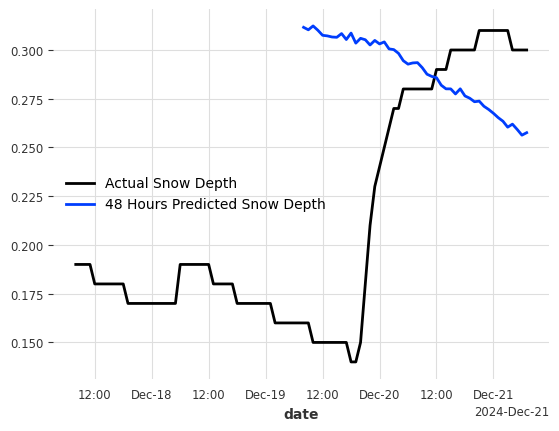

In [ ]:
actual_snowdepth_series.plot(label="Actual Snow Depth")
pred48h.plot(label="48 Hours Predicted Snow Depth")
plt.legend()
plt.show();